In [ ]:
#|hide
#|eval: false
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [ ]:
#|hide
#|eval: false
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [ ]:
#|default_exp agents.dqn.categorical

In [ ]:
#|export
# Python native modules
import os
from collections import deque
from typing import *
from copy import copy
# Third party libs
from fastcore.all import *
import torchdata.datapipes as dp
from torch.utils.data.dataloader_experimental import DataLoader2
from torch.utils.data.datapipes._typing import _DataPipeMeta, _IterDataPipeMeta
from torchdata.dataloader2.graph import find_dps,traverse,DataPipe,remove_dp,replace_dp
import torch
from torch.nn import *
import torch.nn.functional as F
from torch.optim import *
import matplotlib.pyplot as plt
import numpy as np
# Local modules
from fastrl.torch_core import *
from fastrl.core import *
from fastrl.agents.core import *
from fastrl.pipes.core import *
from fastrl.data.block import *
from fastrl.memory.experience_replay import *
from fastrl.agents.core import *
from fastrl.agents.discrete import *
from fastrl.loggers.core import *
from fastrl.loggers.vscode_visualizers import *
from fastrl.learner.core import *
from fastrl.agents.dqn.basic import *
from fastrl.agents.dqn.target import *

# Categorical DQN
> An implimentation of a DQN that uses distributions to represent Q from the paper [A Distributional Perspective on Reinforcement Learning](https://arxiv.org/abs/1707.06887)

The Categorical DQN can be summarized as:
    
    Instead of action outputs being single Q values, they are instead distributions of `N` size.
    
We start off with the idea of atoms and supports. A support acts as a mask over the output action
distributions. This is illistrated by the equations and the corresponding functions.

We start with the equation...

$$
{\large
Z_{\theta}(z,a) = z_i \quad w.p. \: p_i(x,a):= \frac{ e^{\theta_i(x,a)}} {\sum_j{e^{\theta_j(x,a)}}} 
}
$$

... which shows that the end of our neural net model needs to be squished to be a proper probability.
It also defines $z_i$ which is a support we will define very soon.
Below is the implimentation of the right side equation for $p_i(x,a)$

An important note is that $\frac{ e^{\theta_i(x,a)}} {\sum_j{e^{\theta_j(x,a)}}} $ is just:


In [ ]:
Softmax

torch.nn.modules.activation.Softmax

We pretend that the output of the neural net is of shape `(batch_sz,n_actions,n_atoms)`. In this instance,
there is only one action. This implies that $Z_{\theta}$ is just $z_0$.

[<matplotlib.lines.Line2D>]

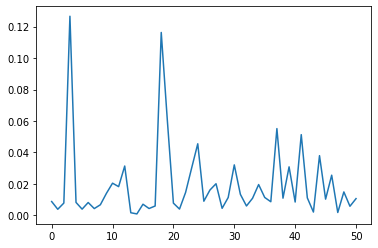

In [ ]:
out=Softmax(dim=1)(torch.randn(1,51,1))[0] # Action 0
plt.plot(out.numpy())

The next function describes how propabilities are calculated from the neural net output. The equation describes a $z_i$ which
is explained by:
$$
\{z_i = V_{min} + i\Delta z : 0 \leq i < N \}, \: \Delta z := \frac{V_{max} - V_{min}}{N - 1}
$$

Where $V_{max}$, $V_{min}$, and $N$ are constants that we define. Note that $N$ is the number of atoms.
So what does a $z_i$ look like? We will define this in code below...

In [ ]:
#|export
def create_support(v_min=-10,v_max=10,n_atoms=51)->Tuple[torch.Tensor,float]:
    "Creates the support and returns the z_delta that was used."
    z_delta=(v_max-v_min)/(n_atoms-1)
    return (torch.Tensor([i*z_delta for i in range(n_atoms)])+v_min,z_delta)

z_delta:  0.4


[<matplotlib.lines.Line2D>]

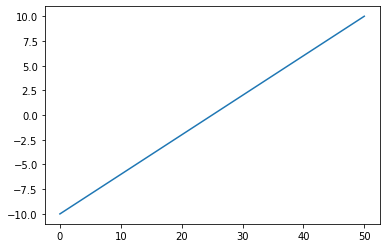

In [ ]:
support_dist,z_delta=create_support()
print('z_delta: ',z_delta)
plt.plot(support_dist.numpy())

This is a single $z_i$ in $Z_{\theta}$. The number of $z_i$s is equal to the number of actions that the DQN is operating with.

> Note: Josiah: Is this always the case? Could there be only $z_0$ and multiple actions?

Ok! Hopefully this wasn't too bad to go through. We basically normalized the neural net output to be nicer to deal with, 
and created/initialized a (bunch) of increasing arrays that we are calling discrete distributions i.e. output from `create_support`.

Now for the fun part! We have this giant ass update equation:

$$
{\large
(\Phi\hat{\mathcal{T}}Z_{\theta}(x,a))_i = \sum_{j=0}^{N-1} \left[ 1 - \frac{ | \mathcal{T}z_j |_{V_{min}}^{V_{max}} - z_i }{ \Delta z } \right]_0^1 p_j(x^{\prime},\pi(x^{\prime}))
}
$$
Good god... and we also have

$$
\hat{\mathcal{T}}z_j := r + \gamma z_j
$$

where, to quote the paper:

<center>
"for each atom $z_j$, [and] then distribute its probability $ p_j(x^{\prime},\pi(x^{\prime})) $ to the immediate neighbors of $ \hat{\mathcal{T}}z_j $"
</center><br>

I highly recommend reading pg6 in the paper for a fuller explaination. I was originally wondering what the difference was between $\pi$ and simple $\theta$, which the main difference is that $\pi$ is a greedy action selection i.e. we run argmax to get the action.

This was a lot! Luckily they have a re-formalation in algorithmic form:

In [ ]:
def categorical_update(v_min,v_max,n_atoms,support,delta_z,model,reward,gamma,action,next_state):
    t_q=(support*Softmax(model(next_state).gather(action))).sum()
    a_star=torch.argmax(t_q)
    
    m=torch.zeros((N,)) # m_i = 0 where i in 1,...,N-1
    
    for j in range(n_atoms):
        # Compute the projection of $ \hat{\mathcal{T}}z_j $ onto support $ z_j $
        target_z=torch.clamp(reward+gamma*support[:,j],v_min,v_max)
        b_j=(target_z-v_min)/delta_z # b_j in [0,N-1]
        l=torch.floor(b_j)
        u=torch.ceil(b_j)
        # Distribute probability of $ \hat{\mathcal{T}}z_j $
        m[:,l]=m[:,l]+a_star*(u-b)
        m[:,u]=m[:,u]+a_star*(b-l)
    return # Some cross entropy loss

There is a small problem with the above equation. This was a (fairly) literal convertion from `Algorithm 1` in the paper to Python.
There are some problems here:<br>
- The current setup doesnt handle batches
- Some of the variables are a little vague
- Does not handle terminal states

Lets rename these! We will instead have:<br>
$$
m\_i    \rightarrow projection\\
a\_star \rightarrow next\_action\\
b\_j    \rightarrow support\_value\\
l      \rightarrow support\_left\\
u      \rightarrow support\_right\\
$$

So lets revise the problem and pretend that we have a 2 action model, batch size of 8, where the last element has a reward of 0, and where
left actions are -1, while right actions are 1.

In [ ]:
from torch.distributions.normal import Normal

So for a single action we would have a distribution like this...

[<matplotlib.lines.Line2D>]

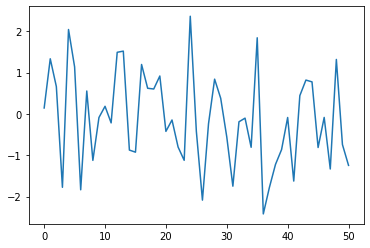

In [ ]:
plt.plot(Normal(0,1).sample((51,)).numpy())

So since our model has 2 actions that it can pick, we create some distributions for them...

In [ ]:
dist_left=torch.vstack([Normal(0.5,1).sample((1,51)),Normal(0.5,0.1).sample((1,51))]).unsqueeze(0)
dist_right=torch.vstack([Normal(0.5,0.1).sample((1,51)),Normal(0.5,1).sample((1,51))]).unsqueeze(0)
(dist_left.shape,dist_right.shape)

(torch.Size([1, 2, 51]), torch.Size([1, 2, 51]))

...where the $[1, 2, 51]$ is $[batch, action, n\_atoms]$

In [ ]:
model_out=torch.vstack([copy([dist_left,dist_right][i%2==0]) for i in range(1,9)]).to(device=default_device())
(model_out.shape)

torch.Size([8, 2, 51])

In [ ]:
summed_model_out=model_out.sum(dim=2);summed_model_out=Softmax(dim=1)(summed_model_out).to(device=default_device())
(summed_model_out.shape,summed_model_out)

(torch.Size([8, 2]),
 tensor([[1.8356e-04, 9.9982e-01],
         [5.4649e-04, 9.9945e-01],
         [1.8356e-04, 9.9982e-01],
         [5.4649e-04, 9.9945e-01],
         [1.8356e-04, 9.9982e-01],
         [5.4649e-04, 9.9945e-01],
         [1.8356e-04, 9.9982e-01],
         [5.4649e-04, 9.9945e-01]], device='cuda:0'))

So when we sum/normalize the distrubtions per batch, per action, we get an output that looks like your typical dqn output...

We can also treat this like a regular DQN and do an argmax to get actions like usual...

In [ ]:
actions=torch.argmax(summed_model_out,dim=1).reshape(-1,1).to(device=default_device());actions

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], device='cuda:0')

In [ ]:
rewards=actions;rewards

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], device='cuda:0')

In [ ]:
dones=torch.Tensor().new_zeros((8,1)).bool().to(device=default_device());dones[-1][0]=1;dones

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True]], device='cuda:0')

So lets decompose the `categorical_update` above into something easier to read. First we will note the author's original algorithm:

<img src="../images/10e_agents.dqn.categorical_algorithm1.png" width="500" height="500">

We can break this into 3 different functions:<br> 
    - getting the Q<br>
    - calculating the update<br>
    - calculating the loss
    
We will start with the $Q(x_{t+1},a):=\sum_iz_ip_i(x_{t_1},a))$

In [ ]:
#|export
class CategoricalDQN(Module):
    def __init__(self,
                 state_sz:int,
                 action_sz:int,
                 n_atoms:int=51,
                 hidden=512,
                 v_min=-10,
                 v_max=10,
                 head_layer=Linear,
                 activation_fn=ReLU
                ):
        store_attr()
        self.layers=Sequential(
            Linear(state_sz,hidden),
            activation_fn(),
            head_layer(hidden,action_sz*n_atoms),
        )
        self.supports,self.z_delta=create_support(v_min=v_min,v_max=v_max,n_atoms=n_atoms)
        self.softmax=Softmax(dim=2)
    
    def to(self, *args, **kwargs):
        self = super().to(*args, **kwargs) 
        self.supports=self.supports.to(*args, **kwargs)
        return self
    
    def forward(self,x): 
        return self.layers(x).view(x.shape[0],self.action_sz,self.n_atoms)
    def policy(self,x): return (self.supports*self.p(x)).mean(dim=2)
    def q(self,x): return (self.supports*self.p(x)).sum(dim=2)
    def p(self,x): return self.softmax(self(x))

The `CategoricalDQN.q` function gets us 90% of the way to the equation above. However, 
you will notice that that equation is for a specific action. We will handle this in the actual update function.

In [ ]:
dqn=CategoricalDQN(4,2).to(device=default_device())
dqn(torch.randn(8,4).to(device=default_device())).shape

torch.Size([8, 2, 51])

In [ ]:
dqn.q(torch.randn(8,4).to(device=default_device()))

tensor([[-0.0801, -0.0976],
        [-0.0832, -0.0276],
        [-0.2771,  0.0913],
        [-0.0317, -0.0598],
        [-0.0009, -0.2392],
        [-0.1135, -0.3386],
        [-0.2643,  0.0126],
        [-0.0355,  0.1925]], device='cuda:0', grad_fn=<SumBackward1>)

In [ ]:
dqn.policy(torch.randn(8,4).to(device=default_device()))

tensor([[-1.5543e-03, -4.3768e-03],
        [ 3.3059e-04, -1.3631e-03],
        [-3.6670e-03, -9.5459e-04],
        [-5.0117e-03, -8.2752e-03],
        [-1.7166e-03,  3.9305e-03],
        [-4.8097e-03, -6.8665e-05],
        [-1.8764e-03, -2.7565e-03],
        [ 7.7792e-05, -3.4387e-03]], device='cuda:0', grad_fn=<MeanBackward1>)

In [ ]:
#|export
def distribute(projection,left,right,support_value,p_a,atom,done):
    "Does: m_l <- m_l + p_j(x_{t+1},a*)(u - b_j) operation for non-final states."
    diffs=torch.hstack((support_value-left,right-support_value))
    # If they are the same location, then just split the value in half, and add twice
    diffs[(left==right).reshape(-1,),:]=0.5 
    mask=~done.reshape(-1,)
    
    left_v=projection[mask].gather(1,left[mask])+(p_a[:,atom][mask]*diffs[:,0][mask]).reshape(-1,1)
    right_v=projection[mask].gather(1,right[mask])+(p_a[:,atom][mask]*diffs[:,1][mask]).reshape(-1,1)
    
    projection[mask]=projection[mask].scatter(dim=1,index=left[mask],src=left_v)
    projection[mask]=projection[mask].scatter(dim=1,index=right[mask],src=right_v)

def final_distribute(projection,left,right,support_value,p_a,atom,done):
    "Does: m_l <- m_l + p_j(x_{t+1},a*)(u - b_j) operation for final states."
    diffs=torch.hstack((support_value-left,right-support_value))
    # If they are the location, then just split the value in half, and add twice
    diffs[(left==right).reshape(-1,),:]=0.5 
    mask=done.reshape(-1,)
    
    left_v=diffs[:,0].reshape(-1,1)
    right_v=projection[mask].gather(1,right)+diffs[:,1].reshape(-1,1)

    projection[mask]=0.0
    projection[mask]=projection[mask].scatter(dim=1,index=left,src=left_v)
    projection[mask]=projection[mask].scatter(dim=1,index=right,src=right_v)

In [ ]:
#|export
def categorical_update(support,delta_z,q,p,actions,rewards,dones,v_min=-10,
                       v_max=10,n_atoms=51,gamma=0.99,passes=None,nsteps=1,debug=False):
    if debug:
        print(f'support: {support.shape}, delta_z: {delta_z}, q: {q.shape}\n',
              f'\tp: {p.shape}, actions: {actions.shape}, rewards: {rewards.shape}\n',
              f'\tdones: {dones.shape}')
    
    bs=q.shape[0]
    passes=ifnone(passes,n_atoms)
    # Do this outside of the loop so we only have to do it once
    # Represents: p_j(x_{t+1},a*)
    p_a=p[torch.arange(bs),actions.reshape(-1,)]#.reshape(-1,1)
    # get a*
    next_actions=torch.argmax(q,dim=1)
    # m_i = 0 for i in [0,N-1]
    projection=torch.zeros((bs,n_atoms)).to(device=default_device())
    # j in [0, N - 1]
    for atom in range(0,passes):
        # Tz_j <- [r_t + gamma * z_j]_v_min^v_max
        target_z=rewards+(gamma**nsteps)*support[atom]
        target_z[dones.reshape(-1)]=rewards[dones.reshape(-1)].float()
        target_z=torch.clamp(target_z,v_min,v_max)
        # b_j <- (Tz_j - Vmin)/delta_z
        support_value=(target_z-v_min)/delta_z
        # l <- floor(b_j), u <- ceil(b_j)
        left,right=support_value.floor().long(),support_value.ceil().long()
        # m_l <- m_l + p_j(x_{t+1},a*)(u - b_j)
        distribute(projection,left,right,support_value,p_a,atom,dones)

    if dones.sum()>=1:
        target_z=rewards[dones.reshape(-1)]
        target_z=torch.clamp(target_z,v_min,v_max)
        support_value=(target_z-v_min)/delta_z
        left,right=support_value.floor().long(),support_value.ceil().long()
        final_distribute(projection,left,right,support_value,p_a,atom,dones)
    return projection

In [ ]:
#|export
def show_q_distribution(cat_dist,title='Update Distributions'):
    "`cat_dist` being shape: (bs,n_atoms)"
    from IPython.display import HTML
    import plotly.graph_objects as go
    fig = go.Figure(data=[go.Surface(z=to_detach(cat_dist).numpy())])
    fig.update_layout(title=title,autosize=False,
                      width=500, height=500,#template='plotly_dark',
                      margin=dict(l=65, r=50, b=80, t=90))
    return HTML(fig.to_html())

In [ ]:
# output=categorical_update(dqn.supports,dqn.z_delta,summed_model_out,
#                           Softmax(dim=2)(model_out),actions,rewards,dones,passes=None)
# show_q_distribution(output)

In [ ]:
# q=dqn.q(torch.randn(8,4).to(device=default_device()))
# p=dqn.p(torch.randn(8,4).to(device=default_device()))

# output=categorical_update(dqn.supports,dqn.z_delta,q,p,actions,rewards,dones)
# show_q_distribution(output,title='Real Model Update Distributions')

In [ ]:
#|export
def PartialCrossEntropy(p,q): return (-p*q).sum(dim=1).mean()

In [ ]:
#|export
class CategoricalTargetQCalc(dp.iter.IterDataPipe):
    debug = False
    
    def __init__(self,source_datapipe,discount=0.99,nsteps=1,device=None,double_dqn_strategy=False):
        self.source_datapipe = source_datapipe
        self.discount = discount
        self.nsteps = nsteps
        self.device = device
        self.double_dqn_strategy = double_dqn_strategy
        if source_datapipe is not None: self.learner = find_dp(traverse(self),LearnerBase)
        
    def reset(self):
        self.learner = find_dp(traverse(self),LearnerBase)
        
    def __iter__(self):
        for batch in self.source_datapipe:            
            if self.device is not None: batch = batch.device(self.device)
            actions = batch.action.long()
            self.learner.done_mask = batch.terminated.reshape(-1,)
            with torch.no_grad():
                target_actions = actions
                if self.double_dqn_strategy:
                    target_actions = self.learner.model.policy(batch.next_state).argmax(dim=1).reshape(-1,)
                    target_actions = target_actions.long()
                
                distribution_m = categorical_update(self.learner.target_model.supports,
                                          self.learner.target_model.z_delta,
                                          self.learner.target_model.q(batch.next_state),
                                          self.learner.target_model.p(batch.next_state),
                                          target_actions,batch.reward,
                                          self.learner.done_mask,nsteps=self.nsteps,
                                          debug=self.debug)
            self.learner.target_qs = distribution_m # (distribution_m,)
            v = self.learner.model(batch.state)
            self.learner.pred_raw = v[np.arange(v.shape[0]),actions.reshape(-1,),:]
            self.learner.pred = F.log_softmax(self.learner.pred_raw,dim=1)
            yield batch
    
    @classmethod
    def replace_remove_dp(cls,
                          old_dp=(QCalc,TargetModelQCalc),
                          rm_dp=(TargetCalc,),
                          device=None,
                          discount=0.99,
                          nsteps=1,
                          double_dqn_strategy=False
                         ) -> Callable[[DataPipe],DataPipe]:
        def _replace_remove_dp(pipe):
            found = False
            for _old_dp in old_dp:
                try:
                    old_dp_instance = find_dp(traverse(pipe),_old_dp)
                    v = replace_dp(
                        traverse(pipe),
                        old_dp_instance,
                        cls(old_dp_instance.source_datapipe,device=device,discount=discount,nsteps=nsteps,
                            double_dqn_strategy=double_dqn_strategy)
                    )
                    pipe = list(v.values())[0][0]
                    found = True
                except LookupError: pass
            if not found: 
                warn(f'Unable to find any: {old_dp} to replace with {cls} given {traverse(pipe)}')
            found = False
            for _rm_dp in rm_dp:
                try:
                    old_dp_instance = find_dp(traverse(pipe),_rm_dp)
                    v = remove_dp(
                        traverse(pipe),
                        old_dp_instance
                    )
                    pipe = list(v.values())[0][0]
                    found = True
                except LookupError: pass
                except RuntimeError:
                    print(traverse(pipe))
                    raise
            if not found: 
                warn(f'Unable to find any: {rm_dp} to replace with {cls} given {traverse(pipe)}')
            return pipe
        return _replace_remove_dp

In [ ]:
#|export
class MultiModelRunner(dp.iter.IterDataPipe):
    "If a model contains multiple models, then we support selecting a sub model."
    def __init__(self,
                 source_datapipe,
                 device:Optional[str]=None,
                 model_name:str='policy'
                ): 
        self.source_datapipe = source_datapipe
        self.agent_base = find_dp(traverse(self),AgentBase)
        self.model = getattr(self.agent_base.model,model_name)
        self.device = device
    
    def __iter__(self):
        for x in self.source_datapipe:
            if self.device is not None: 
                x = x.to(torch.device(self.device))
            if len(x.shape)==1: x = x.unsqueeze(0)
            yield self.model(x)
            
    @classmethod
    def _replace_dp(cls,pipe,old_dp=SimpleModelRunner,device=None,model_name:str='policy'):
        old_dp_instance = find_dp(traverse(pipe),old_dp)
        v = replace_dp(
            traverse(pipe),
            old_dp_instance,
            cls(old_dp_instance.source_datapipe,device=device,model_name=model_name)
        )
        return list(v.values())[0][0]
            
    @classmethod
    def replace_dp(cls,old_dp=SimpleModelRunner,device=None,model_name:str='policy') -> Callable[[DataPipe],DataPipe]:
        return partial(cls._replace_dp,old_dp=old_dp,device=device,model_name=model_name)

In [ ]:
from torchdata.datapipes.utils import to_graph
from fastrl.envs.gym import *
from fastrl.agents.dqn.target import *

In [ ]:
#|eval: false
# Setup Loggers
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
torch.manual_seed(0)
model = CategoricalDQN(4,2).to(device='cuda')
# Setup the Agent
agent = DQNAgent(model,[logger_base],max_steps=4000,device='cuda',
                dp_augmentation_fns=[
                    MultiModelRunner.replace_dp(device='cuda')
])
# Setup the DataBlock
block = DataBlock(
    GymTransformBlock(agent=agent,nsteps=2,nskips=2,firstlast=True), # We basically merge 2 steps into 1 and skip. 
    (GymTransformBlock(agent=agent,nsteps=2,nskips=2,firstlast=True,n=100,include_images=True),VSCodeTransformBlock())
)
# pipes = L(block.datapipes(['CartPole-v1']*1,n=10))
dls = L(block.dataloaders(['CartPole-v1']*1))
# Setup the Learner
learner = DQNLearner(model,dls,logger_bases=[logger_base],bs=128,
                     batches=1000,
                     loss_func = PartialCrossEntropy,
                     device='cuda',
                     max_sz=100_000,
                     lr=0.001,
                     dp_augmentation_fns=[
                         TargetModelUpdater.insert_dp(),
                         CategoricalTargetQCalc.replace_remove_dp(device='cuda',nsteps=2,double_dqn_strategy=True)
                     ])
learner.fit(1)
# learner.fit(7)

loss,episode,rolling_reward,epoch,batch,epsilon
2.783526,75,27.500000,0,1001,0.527250


Creating gif from 100 frames


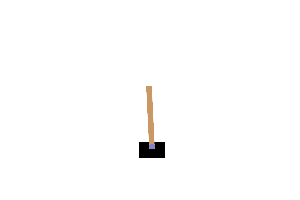

In [ ]:
#|hide
#|eval: false
learner.validate()

In [ ]:
from IPython.display import HTML
import plotly.express as px
from torchdata.dataloader2.graph import find_dps,traverse

In [ ]:
#|export
def show_q(cat_dist,title='Update Distributions'):
    "`cat_dist` being shape: (bs,n_atoms)"
    from IPython.display import HTML
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    distributions=to_detach(cat_dist).numpy()
    actions=np.argmax(distributions,axis=1).reshape(-1,)
    fig = make_subplots(rows=1, cols=2,
                        specs=[[{"type": "surface"},{"type": "xy"}]])
    fig.add_trace(go.Surface(z=distributions, showscale=False),row=1, col=1)
    fig.add_trace(go.Scatter(x=np.arange(len(actions)),y=actions),row=1, col=2)
    fig.update_layout(title=title,autosize=False,
                      width=1000, height=500,#template='plotly_dark',
                      margin=dict(l=65, r=50, b=80, t=90))
    return HTML(fig.to_html())

In [ ]:
#|hide
#|eval: false
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev import nbdev_export
    nbdev_export()